In [1]:
% matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import glob
import numpy.ma as ma

import gsw as sw
from mpl_toolkits.basemap import Basemap, cm, interp

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
rcParams.update({'font.family': 'serif'})
rcParams.update({'font.serif': 'Times New Roman'})

import scipy.stats as st

/Users/archie/anaconda/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


In [2]:
# import data

maxlon = 171
minlon = 130

Tok1 = pd.read_csv('../data/Tokyo1_chl.csv', sep=',')

Tok1['dlat'] = np.insert(np.diff(Tok1['Lat']), 0, 0)
Tok1 = Tok1[np.abs(Tok1['dlat'])<0.08]

Tok3 = pd.read_csv('../data/Tokyo3_chl.csv', sep = ',')
Tok3['density'] = sw.rho(Tok3['S'].values,Tok3['T'].values,0)

Tian = pd.read_csv('../data/Tian_chl.csv', sep = ',')
Tian['density'] = sw.rho(Tian['S'].values,Tian['T'].values,0)


print Tian.columns

Index([u'Unnamed: 0', u'Timestamp', u'Lat', u'Lon', u'S', u'T', u'Fluo',
       u'TrueO2Ar', u'O2Arsat', u'O2Arbiosat', u'MLD (WOA13)', u'Wkn',
       u'Air-sea flux', u'density', u'dx', u'x', u'chl'],
      dtype='object')


In [3]:
# import SSH data

files = glob.glob('../data/sla/*.nc')
#print files

Tok1_SSH = Dataset(files[0], mode='r')

slaT = ma.getdata(np.squeeze(Tok1_SSH.variables['sla'][:]))

lons = Tok1_SSH.variables['lon'][:]
lats = Tok1_SSH.variables['lat'][:]

ncp = Tok1['chl'].values
temp = Tok1['T'].values

Tok1_SSH.close()

temp_track = []
ncp_track = []
sla_track = []
new_lat = []
spacing = 0.25

x = lons
y = lats

xnew = Tok1['Lon'].values
ynew = Tok1['Lat'].values

x = np.arange(140, 160.25, 0.25)

for n in range(len(x)):
    
    k = np.where((xnew < (x[n] + (spacing*0.5))) & (xnew > (x[n] - (spacing*0.5))))   
    l = np.mean(ynew[k])
    m = np.mean(ncp[k])
    o = np.mean(temp[k])
    
    # now need to find SLA value to coincide with NCP
    ll = np.where((lats>=(l - (spacing*0.5))) & (lats<=(l + (spacing*0.5))))
    mm = np.where((lons>=(x[n] - (spacing*0.5))) & (lons<(x[n] + (spacing*0.5))))
   
    ss = np.asscalar(np.mean(np.squeeze(slaT[ll,mm][0])))

    if np.isfinite(m) & np.isfinite(l):
        ncp_track.append(m)
        temp_track.append(o)
        new_lat.append(l)
        sla_track.append(ss)
    else:
        ncp_track.append(np.nan)
        temp_track.append(np.nan)
        new_lat.append(np.nan)
        sla_track.append(np.nan)

    #print xnew[n], ynew[n], k, l, m

#plt.scatter(sla_track, ncp_track, s = 20, lw = 0)

dtab = pd.DataFrame()
dtab['sla'] = sla_track
dtab['ncp'] = ncp_track
dtab['lat'] = new_lat
dtab['temp'] = temp_track 
dtabT1 = dtab.dropna()

mx, cx, rx, px, std_err = st.linregress(dtabT1['sla'], dtabT1['ncp'])
print 'estimated slope = ', mx, ', r = ', rx, ', p-value < 0.05 ', px<0.05

subset1 = dtabT1[dtabT1['temp']<18]

mx, cx, rx, px, std_err = st.linregress(subset1['sla'], subset1['ncp'])
print 'estimated slope = ', mx, ', r = ', rx, ', p-value < 0.05 ', px

subset = dtabT1[dtabT1['temp']>18]

mxtt, cxtt, rxtt, pxtt, std_errtt = st.linregress(subset['sla'], subset['ncp'])
print 'estimated slope = ', mxtt, ', r = ', rxtt, ', p-value < 0.05 ', pxtt

subset.corr()

estimated slope =  -0.468878443789 , r =  -0.47513046355 , p-value < 0.05  True
estimated slope =  0.0730454906036 , r =  0.0439860638367 , p-value < 0.05  0.764101541959
estimated slope =  -0.00115520610545 , r =  -0.0208986516086 , p-value < 0.05  0.928354960516


/Users/archie/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


,sla,ncp,lat,temp
sla,1.000000,-0.020899,0.273995,0.152188
ncp,-0.020899,1.000000,0.192640,-0.423109
lat,0.273995,0.192640,1.000000,-0.368915
temp,0.152188,-0.423109,-0.368915,1.000000


In [4]:
Tok3_SSH = Dataset(files[2], mode='r')
slaT = np.squeeze(Tok3_SSH.variables['sla'][:])
lons = Tok3_SSH.variables['lon'][:]
lats = Tok3_SSH.variables['lat'][:]

ncp = Tok3['chl'].values
temp = Tok3['T'].values

Tok3_SSH.close()

temp_track = []
ncp_track = []
sla_track = []
new_lat = []
spacing = 0.25

x = lons
y = lats

xnew = Tok3['Lon'].values
ynew = Tok3['Lat'].values

x = np.arange(140, 160.25, 0.25)

for n in range(len(x)):
    
    k = np.where((xnew < (x[n] + (spacing*0.5))) & (xnew > (x[n] - (spacing*0.5))))   
    l = np.mean(ynew[k])
    m = np.mean(ncp[k])
    p = np.mean(temp[k])
    
    # now need to find SLA value to coincide with NCP
    ll = np.where((lats>=(l - (spacing*0.5))) & (lats<=(l + (spacing*0.5))))
    mm = np.where((lons>=(x[n] - (spacing*0.5))) & (lons<(x[n] + (spacing*0.5))))
   
    ss = np.asscalar(np.mean(np.squeeze(slaT[ll,mm][0])))

    if np.isfinite(m) & np.isfinite(l):
        temp_track.append(p)
        ncp_track.append(m)
        new_lat.append(l)
        sla_track.append(ss)
    else:
        ncp_track.append(np.nan)
        temp_track.append(np.nan)
        new_lat.append(np.nan)
        sla_track.append(np.nan)

    #print xnew[n], ynew[n], k, l, m

#plt.scatter(sla_track, ncp_track, s = 20, lw = 0)


dtab = pd.DataFrame()
dtab['sla'] = sla_track
dtab['ncp'] = ncp_track
dtab['lat'] = new_lat
dtab['temp'] = temp_track
dtabT3 = dtab.dropna()

mx3, cx3, rx3, px3, std_err = st.linregress(dtabT3['sla'], dtabT3['ncp'])
print 'estimated slope = ', mx3, ', r = ', rx3, ', p-value < 0.05 ', px3<0.05

# plt.plot(np.arange(-0.6, 0.8, 0.01), mx*np.arange(-0.6, 0.8, 0.01)+cx, 'r')
# plt.show()

dtabT3.corr()

estimated slope =  -0.0267713547389 , r =  -0.329472143025 , p-value < 0.05  True


,sla,ncp,lat,temp
sla,1.000000,-0.329472,-0.360617,0.592564
ncp,-0.329472,1.000000,0.561539,-0.566554
lat,-0.360617,0.561539,1.000000,-0.796309
temp,0.592564,-0.566554,-0.796309,1.000000


In [5]:
T_SSH = Dataset(files[5], mode='r')
slaT = np.squeeze(T_SSH.variables['sla'][:])
lons = T_SSH.variables['lon'][:]
lats = T_SSH.variables['lat'][:]

ncp = Tian['chl'].values
temp = Tian['T'].values

T_SSH.close()

temp_track = []
ncp_track = []
sla_track = []
new_lat = []
spacing = 0.25

x = lons
y = lats

xnew = Tian['Lon'].values
ynew = Tian['Lat'].values

x = np.arange(140, 160.25, 0.25)

for n in range(len(x)):
    
    k = np.where((xnew < (x[n] + (spacing*0.5))) & (xnew > (x[n] - (spacing*0.5))))   
    l = np.mean(ynew[k])
    m = np.mean(ncp[k])
    p = np.mean(temp[k])
    
    # now need to find SLA value to coincide with NCP
    ll = np.where((lats>=(l - (spacing*0.5))) & (lats<=(l + (spacing*0.5))))
    mm = np.where((lons>=(x[n] - (spacing*0.5))) & (lons<(x[n] + (spacing*0.5))))
   
    ss = np.asscalar(np.mean(np.squeeze(slaT[ll,mm][0])))

    if np.isfinite(m) & np.isfinite(l):
        temp_track.append(p)
        ncp_track.append(m)
        new_lat.append(l)
        sla_track.append(ss)
    else:
        ncp_track.append(np.nan)
        temp_track.append(np.nan)
        new_lat.append(np.nan)
        sla_track.append(np.nan)

    #print xnew[n], ynew[n], k, l, m

#plt.scatter(new_lat, ncp_track, s = 20, lw = 0)

dtab = pd.DataFrame()
dtab['sla'] = sla_track
dtab['ncp'] = ncp_track
dtab['lat'] = new_lat
dtab['temp'] = temp_track
dtabTian = dtab.dropna()

mxt, cxt, rxt, pxt, std_errt = st.linregress(dtabTian['sla'], dtabTian['ncp'])
print 'estimated slope = ', mxt, ', r = ', rxt, ', p-value < 0.05 ', pxt<0.05

# #plt.plot(np.arange(34, 42, 0.5), mx*np.arange(34, 42, 0.5)+cx, 'r')
# plt.show()


subset1 = dtabTian[dtabTian['temp']<18]

mxst, cxst, rxst, pxst, std_errst = st.linregress(subset1['sla'], subset1['ncp'])
print 'estimated slope = ', mxst, ', r = ', rxst, ', p-value < 0.05 ', pxst<0.05

subset = dtabTian[dtabTian['temp']>18]

mxss, cxss, rxss, pxss, std_errss = st.linregress(subset['sla'], subset['ncp'])
print 'estimated slope = ', mxss, ', r = ', rxss, ', p-value < 0.05 ', pxss<0.05

print subset1.corr()
print subset.corr()

estimated slope =  0.653057149739 , r =  0.36279875346 , p-value < 0.05  True
estimated slope =  0.287830854818 , r =  0.0402101690236 , p-value < 0.05  False
estimated slope =  0.0678141358954 , r =  0.146501103421 , p-value < 0.05  False
           sla       ncp       lat      temp
sla   1.000000  0.040210 -0.250061  0.500927
ncp   0.040210  1.000000  0.678580 -0.162985
lat  -0.250061  0.678580  1.000000 -0.531005
temp  0.500927 -0.162985 -0.531005  1.000000
           sla       ncp       lat      temp
sla   1.000000  0.146501  0.036438  0.149435
ncp   0.146501  1.000000  0.539312 -0.544081
lat   0.036438  0.539312  1.000000 -0.908307
temp  0.149435 -0.544081 -0.908307  1.000000


/Users/archie/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


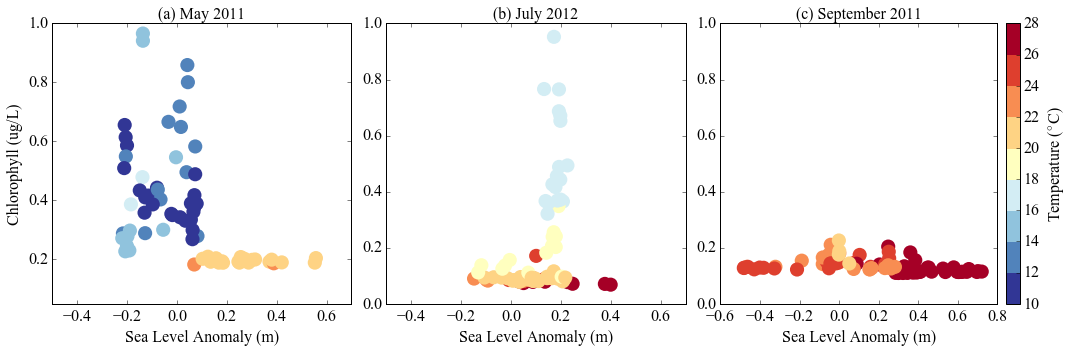

In [6]:
# make a 3 panel plot showing the relationship for each cruise between SLA and NCP
palette = plt.get_cmap('RdYlBu_r', 9)
fig1, (ax1, ax3, ax2) = plt.subplots(1,3, figsize = (15,5), dpi = 300)
# fig1, (ax1, ax3) = plt.subplots(1, 2, figsize = (12, 6), dpi = 300)

nn = 16

ax1.scatter(dtabT1['sla'], dtabT1['ncp'], s=200, c=dtabT1['temp'] , lw = 0, cmap = palette, vmin = 10, vmax = 28)
# ax1.plot(np.arange(-0.35, 0.2, 0.01), mx*np.arange(-0.35, 0.2, 0.01)+cx, color = 'blue', lw =3)
# ax1.plot(np.arange(0.0, 0.6, 0.01), mxtt*np.arange(0.0, 0.6, 0.01)+cxtt, color = 'r', lw =3)
# ax1.plot(np.arange(0.0, 0.6, 0.01), mx*np.arange(0.0, 0.6, 0.01)+cx, color = 'k', lw =3)


ax1.set_xlim([-0.5, 0.7])
ax1.set_ylim([0.05, 1.0])
ax1.set_ylabel('Chlorophyll (ug/L)', fontsize=nn)
ax1.set_xlabel('Sea Level Anomaly (m)', fontsize = nn)
ax1.set_title('(a) May 2011', fontsize = nn)
ax1.tick_params(labelsize = nn)

# ax2.plot(dtabT3['sla'], dtabT3['ncp'], '.k', lw = 0, markersize = 10)
ax2.scatter(dtabT3['sla'], dtabT3['ncp'], s=200, c=dtabT3['temp'] , lw = 0, cmap = palette, vmin = 10, vmax = 28)

ax2.set_xlim([-0.6, 0.8])
ax2.set_ylim([0.0, 1.0])
ax2.set_xlabel('Sea Level Anomaly (m)', fontsize=nn)
ax2.set_title('(c) September 2011', fontsize = nn)
ax2.tick_params(labelsize = nn)

ss = ax3.scatter(dtabTian['sla'], dtabTian['ncp'], s=200, c=dtabTian['temp'], lw = 0, cmap = palette, vmin = 10, vmax = 28)
ax3.set_xlim([-0.5, 0.7])
ax3.set_ylim([0.0, 1.0])
ax3.set_title('(b) July 2012', fontsize = nn)
ax3.tick_params(labelsize = nn)
ax3.set_xlabel('Sea Level Anomaly (m)', fontsize = nn)

# ax2.plot(np.arange(-0.55, 0.75, 0.01), mx3*np.arange(-0.55, 0.75, 0.01)+cx3, 'r', lw =3)


# fig1.subplots_adjust(right=0.8)

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
cb = plt.colorbar(ss, cax=cax)

plt.tight_layout()

# cbar_ax = fig1.add_axes([1.0, 0.12, 0.02, 0.82])
# cb = plt.colorbar(ss, cax=cbar_ax)
cb.set_label('Temperature ($^{\circ}$C)', fontsize = nn)
cb.ax.tick_params(labelsize=nn)
fig1.tight_layout()
plt.show()

fig1.savefig('../manuscript/FigSupCHL_SLA.png', dpi = 300)

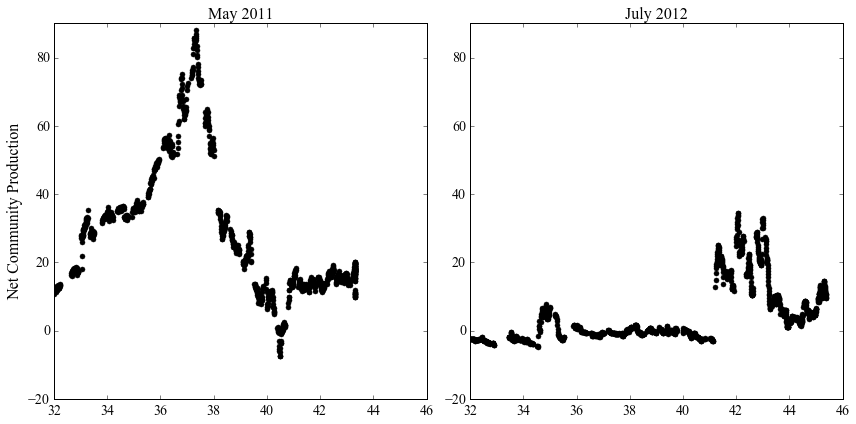

In [7]:
# make a 3 panel plot showing the relationship for each cruise between SLA and NCP

# fig2, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12, 4), dpi = 300)
fig2, (ax1, ax3) = plt.subplots(1, 2, figsize = (12, 6), dpi = 300)


ax1.plot(Tok1['Lat'], Tok1['Air-sea flux'], '.k', lw = 0, markersize = 10)
ax1.set_xlim([32, 46])
ax1.set_ylim([-20, 90])
ax1.set_ylabel('Net Community Production', fontsize=16)
ax1.set_title('May 2011', fontsize = 16)
ax1.tick_params(labelsize = 14)

# ax2.plot(Tok3['Lat'], Tok3['Air-sea flux'], '.k', lw = 0, markersize = 10)
# ax2.set_xlim([32, 46])
# ax2.set_ylim([-20, 90])
# ax2.set_xlabel('Latitude ($^o$)', fontsize=16)
# ax2.set_title('September 2011', fontsize = 16)
# ax2.tick_params(labelsize = 14)

ax3.plot(Tian['Lat'], Tian['Air-sea flux'], '.k', lw = 0, markersize = 10)
ax3.set_xlim([32, 46])
ax3.set_ylim([-20, 90])
ax3.set_title('July 2012', fontsize = 16)
ax3.tick_params(labelsize = 14)

plt.show()

#fig2.savefig('../figures/NCP_LAT_scatter.png', dpi = 300)